In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import nltk
import string
from nltk.corpus import stopwords
from spellchecker import SpellChecker
from wordcloud import WordCloud
from typing import Union
import matplotlib.cm as cm
from collections import Counter
from typing import List, Tuple
import unicodedata
from langdetect import detect, LangDetectException

In [7]:
"""nltk.download('punkt')
nltk.download('stopwords')"""

"nltk.download('punkt')\nnltk.download('stopwords')"

### Project Description:

The goal was to classify 160,000 comments into six toxicity labels. The dataset was imbalanced, with approximately 90% non-toxic and 10% toxic comments. The six labels had varying frequencies, with the most extreme and disturbing comments being the rarest.

My EDA focused on understanding the words used in comments and their relationships to the assigned labels. This included analyzing word frequencies, correlations, and other text characteristics. Some of the findings were surprising, such as the higher frequency of typos in non-toxic comments and the frequent appearance of the word "wikipedia" in toxic comments.

Despite personal reservations about online censorship, this project provided insights into the backend processes of social media platforms for comment filtering.

#### What Was Done:

- EDA Tasks:
- Checked for missing values and duplicates
- Analyzed label distributions
- Studied word frequencies per label and overall word usage
- Explored correlations between labels and word frequencies
- Visualized various findings from the EDA
- Examined comment lengths
- Analyzed typo frequencies in toxic and non-toxic comments
- Calculated capitalization ratios
- Evaluated comment lengths from both word and character perspectives
- These steps provided a comprehensive understanding of the data, guiding the subsequent model development phase.

### Data loading and inspection

In [8]:
train_df = pd.read_csv(
    '/home/user/Documents/jigsaw-toxic-comment-classification-challenge/train.csv')
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


---
- Dataset contains 159 571 instances.
- 6 available labels per comment. 
---

### Missing values

In [10]:
print(train_df.isnull().sum())

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


---
- No missing values
---

### Duplicates

In [11]:
train_df['comment_text'].duplicated().sum()

0

----
- No comment text duplicates

---

In [12]:
train_df.drop('id', axis=1, inplace=True)

## EDA

In [13]:
train_df['labels_sum'] = train_df[['toxic', 'severe_toxic',
                                   'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1)
multiple_labels_df = train_df[train_df['labels_sum'] > 1]
num_multiple_labels = multiple_labels_df.shape[0]
print(f"Number of comments with multiple labels: {num_multiple_labels}")

Number of comments with multiple labels: 9865


### Number of comments per category and categories per comment

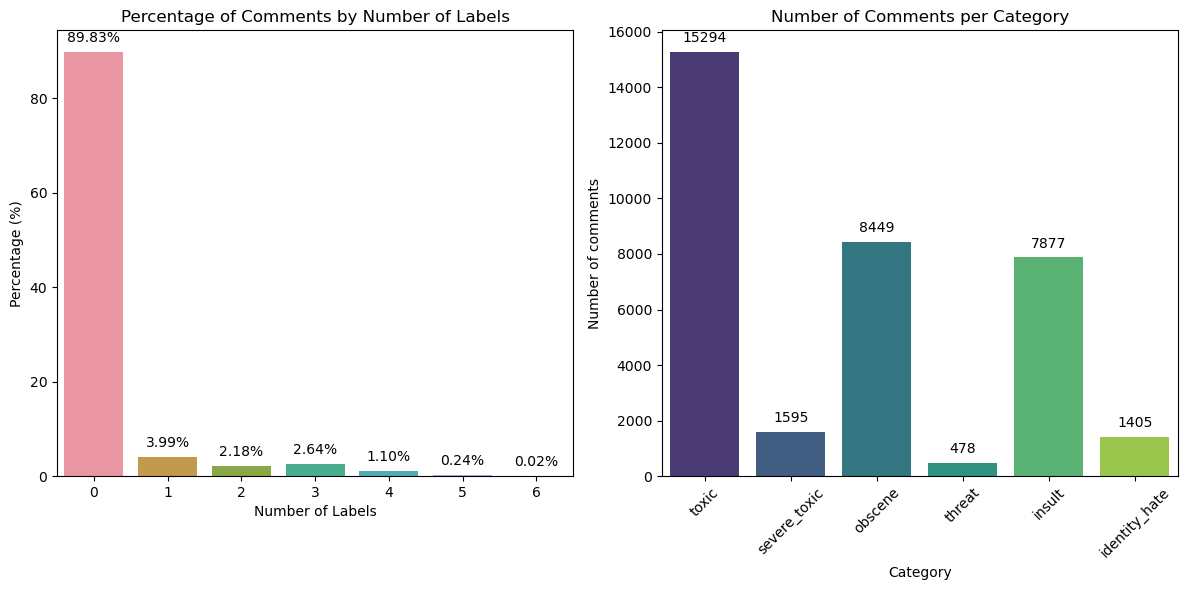

In [14]:
sns.set_palette('viridis')
labels_count = train_df['labels_sum'].value_counts().sort_index()
labels_count_df = labels_count.reset_index()
labels_count_df.columns = ['Number of Labels', 'Count']
total_comments = train_df.shape[0]
labels_count_df['Percentage'] = (
    labels_count_df['Count'] / total_comments) * 100

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
ax1 = sns.barplot(x='Number of Labels', y='Percentage', data=labels_count_df)
plt.title('Percentage of Comments by Number of Labels')
plt.xlabel('Number of Labels')
plt.ylabel('Percentage (%)')
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

label_sums = train_df[['toxic', 'severe_toxic', 'obscene',
                       'threat', 'insult', 'identity_hate']].sum().reset_index()
label_sums.columns = ['Label', 'Count']

plt.subplot(1, 2, 2)
ax2 = sns.barplot(x='Label', y='Count', data=label_sums)
plt.title('Number of Comments per Category')
plt.xlabel('Category')
plt.ylabel('Number of comments')
plt.xticks(rotation=45)
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()

---
- We can see very scewed distribution, where large majority of comments having no labels, meaning they are not labeled as 'toxic'.
- And quite low percentages of comments with more than 3 labels.
- We can see also within comments that more severe labels are less common, with majority of comments being in either of the three most common categories: toxic, obscene or insult. 

---

#### Labels counts

In [15]:
labels_count

labels_sum
0    143346
1      6360
2      3480
3      4209
4      1760
5       385
6        31
Name: count, dtype: int64

In [16]:
labels_columns = ['toxic', 'severe_toxic',
                  'obscene', 'threat', 'insult', 'identity_hate']

### Correlation analysis

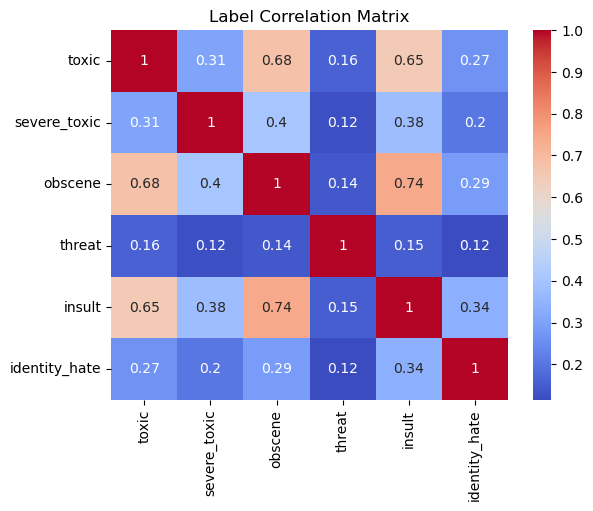

In [17]:
sns.heatmap(train_df[labels_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Label Correlation Matrix')
plt.show()

---
- We se positive correlation amongst all labels, but only few having higher correlation values. 
- Obscene and Insult, Toxic and Obscene
---

### Capitalization ratio

In [18]:
def capitalization_ratio(comment: str) -> float:
    """
    Calculate the ratio of uppercase characters to all alphabetical characters in a comment.
    """

    uppercase_count = sum(1 for c in comment if c.isupper())
    total_alpha_count = sum(1 for c in comment if c.isalpha())

    return uppercase_count / total_alpha_count if total_alpha_count > 0 else 0.0


train_df['cap_ratio'] = train_df['comment_text'].apply(capitalization_ratio)

In [19]:
labels = ['toxic', 'severe_toxic', 'obscene',
          'threat', 'insult', 'identity_hate']
non_toxic_ratio = train_df.loc[train_df[labels].sum(
    axis=1) == 0, 'cap_ratio'].mean()

label_cap_ratios = {}
for label in labels:
    ratio = train_df.loc[
        train_df[label] == 1, 'cap_ratio'].mean()
    label_cap_ratios[label] = ratio

label_cap_ratios['non_toxic'] = non_toxic_ratio

for label, ratio in label_cap_ratios.items():
    print(f"Average capitalization ratio for {label}: {ratio}")

Average capitalization ratio for toxic: 0.1540255987488267
Average capitalization ratio for severe_toxic: 0.2789339871618079
Average capitalization ratio for obscene: 0.1659012169331484
Average capitalization ratio for threat: 0.1973211344495073
Average capitalization ratio for insult: 0.16214798321357501
Average capitalization ratio for identity_hate: 0.18753814013014164
Average capitalization ratio for non_toxic: 0.06044535188308203


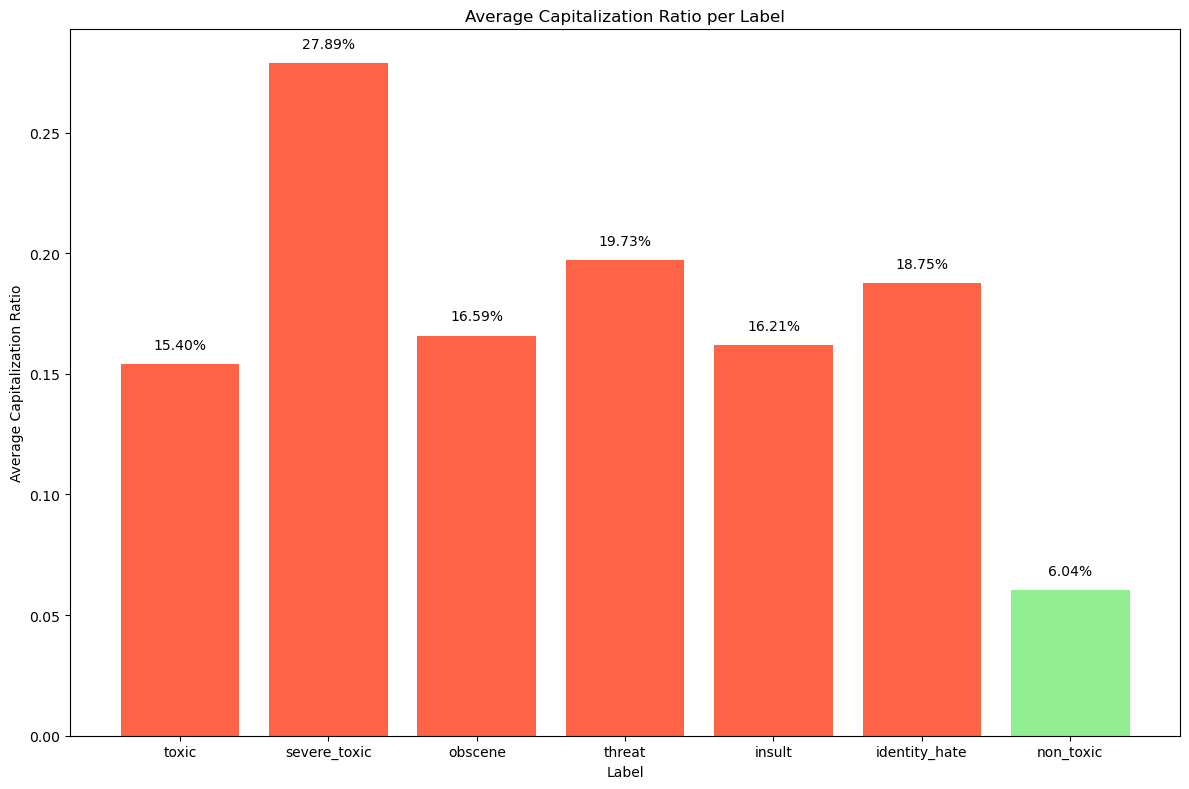

In [20]:
labels = list(label_cap_ratios.keys())
ratios = list(label_cap_ratios.values())
colors = ['lightgreen' if label == 'non_toxic' else 'tomato' for label in labels]
plt.figure(figsize=(12, 8))  
bars = plt.bar(labels, ratios, color=colors)
plt.xlabel('Label')
plt.ylabel('Average Capitalization Ratio')
plt.title('Average Capitalization Ratio per Label')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.2%}", ha='center', va='bottom')
plt.subplots_adjust(bottom=0.15, top=0.85)
plt.tight_layout()
plt.show()

---
- We see relatively similar capitalization ratios in the toxic labels, besides severe_toxic, indicating that this label has more capitalized letters than any other toxic label. 
- When it comes to non_toxic comments, they have the lowest capitalization ratio as expected. 
---

### Symbol usage and frequencies

In [21]:
symbols = set('!@#$%^&*()_+-={}[]:";\'<>?,./|\\~`')
labels = ['toxic', 'severe_toxic', 'obscene',
          'threat', 'insult', 'identity_hate']
symbol_counts = {symbol: {label: 0 for label in labels +
                          ['non_toxic']} for symbol in symbols}

for index, row in train_df.iterrows():
    is_non_toxic = row[labels].sum() == 0

    comment_symbols = Counter(c for c in row['comment_text'] if c in symbols)

    for symbol, count in comment_symbols.items():
        if is_non_toxic:
            symbol_counts[symbol]['non_toxic'] += count
        else:
            for label in labels:
                if row[label]:
                    symbol_counts[symbol][label] += count

symbol_df = pd.DataFrame(symbol_counts).T
symbol_df.head(10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
~,415,250,308,0,61,6,7349
{,166,11,121,58,95,8,6248
#,248,61,180,1,83,50,5973
[,331,52,158,1,108,17,7927
],377,56,162,1,105,20,8459
+,294,60,128,19,78,66,2995
_,1372,335,918,241,512,298,17678
;,666,35,279,9,237,37,21166
?,8949,602,4103,160,3806,619,62151
|,482,66,294,1,240,13,13905


In [22]:
symbol_df['toxic'] = symbol_df[labels].sum(axis=1)

total_toxic = train_df[labels].sum().sum()
total_non_toxic = len(train_df) - \
    train_df[labels].sum(axis=1).astype(bool).sum()

symbol_df['toxic_normalized'] = symbol_df['toxic'] / total_toxic
symbol_df['non_toxic_normalized'] = symbol_df['non_toxic'] / total_non_toxic

symbols = symbol_df.index
toxic_frequencies = symbol_df['toxic_normalized']
non_toxic_frequencies = symbol_df['non_toxic_normalized']

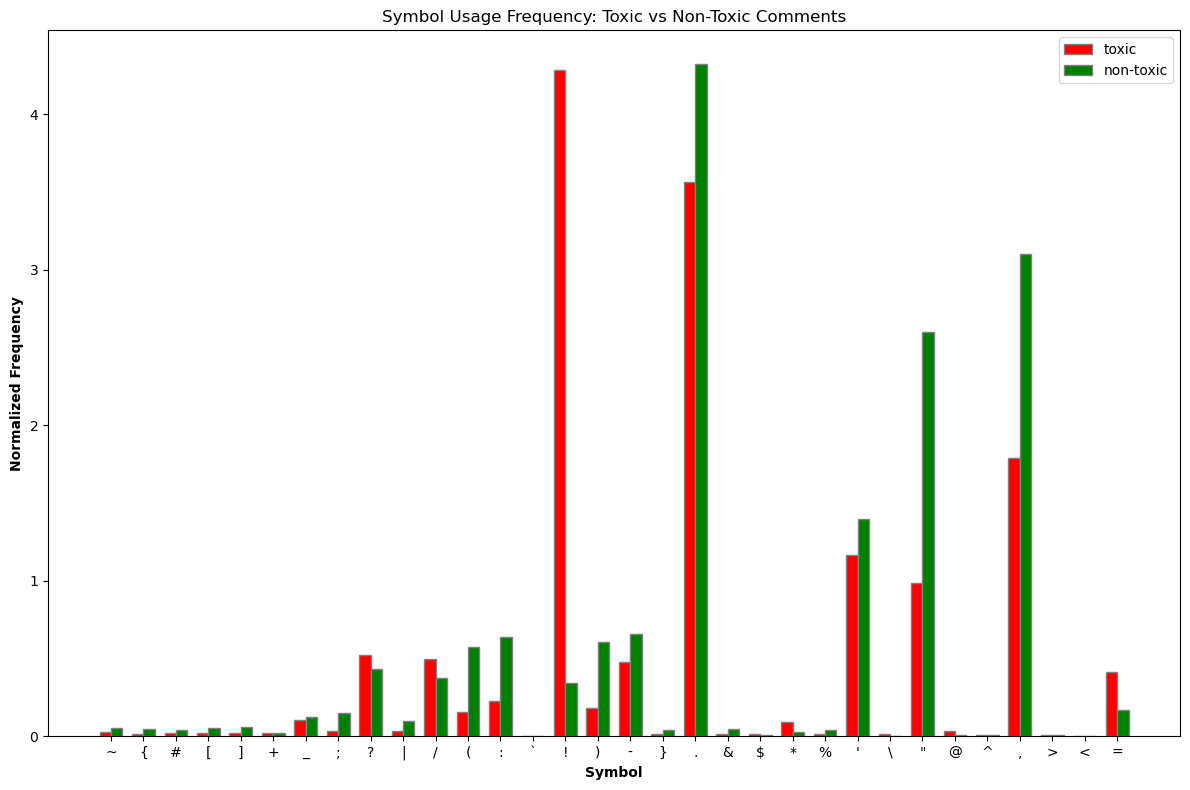

In [23]:
barWidth = 0.35
fig, ax = plt.subplots(figsize=(12, 8))
r1 = np.arange(len(symbols))
r2 = [x + barWidth for x in r1]
plt.bar(r1, toxic_frequencies, color='red',
        width=barWidth, edgecolor='grey', label='toxic')
plt.bar(r2, non_toxic_frequencies, color='green',
        width=barWidth, edgecolor='grey', label='non-toxic')
plt.xlabel('Symbol', fontweight='bold')
plt.ylabel('Normalized Frequency', fontweight='bold')
plt.xticks([r + barWidth / 2 for r in range(len(symbols))], symbols)
plt.legend()
plt.title('Symbol Usage Frequency: Toxic vs Non-Toxic Comments')
plt.tight_layout()
plt.show()

----
- We see that "!" is the most indicative of toxic comments. 
- Non toxic comments seem to have period ( . ), qotation ("") and comma (,) more frequently than toxic ones. 
- "=", "?", "*", "@", "/" Are more frequent in toxic comments.

---

In [24]:
symbol_df

,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,toxic_normalized,non_toxic_normalized
~,1040,250,308,0,61,6,7349,0.029631,0.051268
{,459,11,121,58,95,8,6248,0.013078,0.043587
#,623,61,180,1,83,50,5973,0.017750,0.041668
[,667,52,158,1,108,17,7927,0.019004,0.055300
],721,56,162,1,105,20,8459,0.020542,0.059011
+,645,60,128,19,78,66,2995,0.018377,0.020894
_,3676,335,918,241,512,298,17678,0.104735,0.123324
;,1263,35,279,9,237,37,21166,0.035985,0.147657
?,18239,602,4103,160,3806,619,62151,0.519659,0.433573
|,1096,66,294,1,240,13,13905,0.031227,0.097003


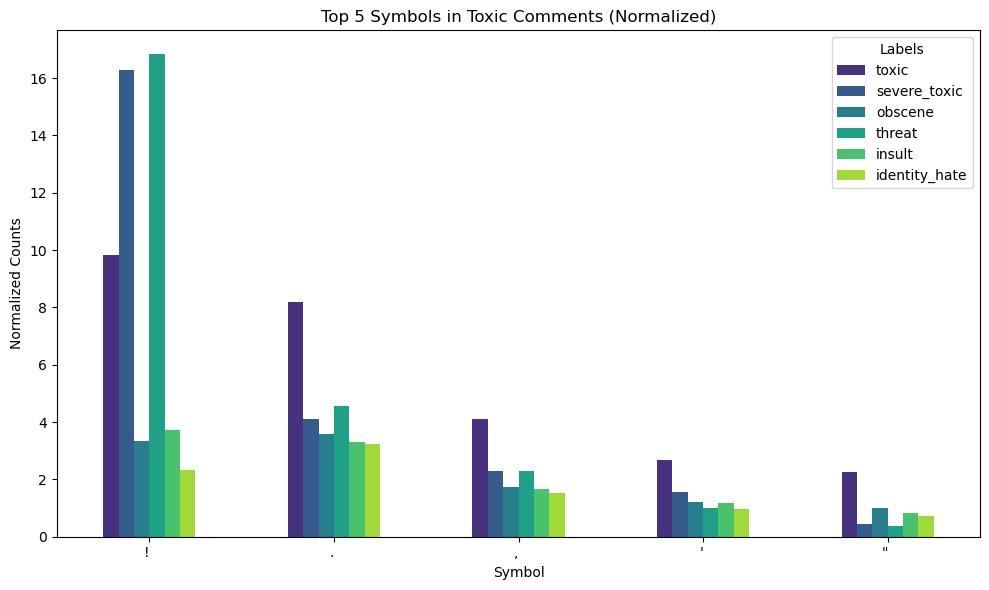

In [25]:
label_totals = {
    'toxic': train_df['toxic'].sum(),
    'severe_toxic': train_df['severe_toxic'].sum(),
    'obscene': train_df['obscene'].sum(),
    'threat': train_df['threat'].sum(),
    'insult': train_df['insult'].sum(),
    'identity_hate': train_df['identity_hate'].sum(),
}

for label in label_totals:
    symbol_df[f'{label}_normalized'] = symbol_df[label] / label_totals[label]

symbol_df['toxic_total_normalized'] = symbol_df[[
    f'{label}_normalized' for label in label_totals.keys()]].sum(axis=1)
top_symbols_normalized = symbol_df.sort_values(
    'toxic_total_normalized', ascending=False).head(5)

fig, ax = plt.subplots(figsize=(10, 6))
top_symbols_normalized[[
    f'{label}_normalized' for label in label_totals.keys()]].plot(kind='bar', ax=ax)
ax.set_title('Top 5 Symbols in Toxic Comments (Normalized)')
ax.set_xlabel('Symbol')
ax.set_ylabel('Normalized Counts')
ax.legend(title='Labels', labels=label_totals.keys())

plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

---

- Other than "!" we see that other symbols are quite simmilar in terms of their frequencies between labels.
- The "!" is mostly prevelant in 'insult' and "severe_toxic" labels.

---

### Showing 3 examples of comments per label of toxicity 

In [26]:
train_df_shuffled = train_df.sample(
    frac=1, random_state=21).reset_index(drop=True)

for label in labels_columns:
    print(f"\nThree example comments for label '{label}':")
    example_comments = train_df_shuffled[train_df_shuffled[label] == 1]['comment_text'].head(
        3).tolist()
    for i, comment in enumerate(example_comments, 1):
        print(f"\nExample {i}:")
        print(comment)
    print("\n" + "-"*80 + "\n")


Three example comments for label 'toxic':

Example 1:
"

 nai caste ka veer 

fuck you all motherfuckers pakistani janjua  muslims

you pigs either lock this talk page too or unlock the talk page of my caste  

""i am become death, the destroyer of pakistani muslims"" , note my ip and locate me and send terrorists to kill me......if you are a true muslim

i have lost the fear of death

fuck you pig 'sitush', you born out of shit of a pig..

teri ma chodu behnchod musalman janjue rajput

bhaag behnchod"

Example 2:
Widr's P3N15 

hey does anybody think that widr is all pissed off and angry all the time because he is sad about the size of his ding dong chingitty chong? 

thanks,
Widr's mom

Example 3:
help
This 'Historian' now thinks that 'Sanhedrin' is closer to Neturei Karta than to Kach. He is also seeing a fusion of Kach and Neturei Karta, since 'both oppose the state'. I tried to clarify it, giving some examples of the thought of NK and Kach (without naming either), and what is his

- We can see some examples of coments labeled as toxic to have better understanding of them. 

### Toxic comment word frequencies, analyzing most frequent insutls words

In [27]:
def clean_text(text: str) -> str:
    """
    Converts text to lowercase, removes punctuation, and eliminates stopwords.
    """
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    stop_words = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]

    return ' '.join(filtered_sentence)


train_df['cleaned_comment_text'] = train_df['comment_text'].apply(clean_text)

In [28]:
def get_most_common_words(texts: List[str], num_top_words: int = 10) -> List[Tuple[str, int]]:
    """
    Identifies the most common words in a series of texts.
    """
    all_words = ' '.join(texts).split()
    most_common_words = Counter(all_words).most_common(num_top_words)
    return most_common_words


for label in labels_columns:
    print(f"Most common words in {label} comments:")
    labeled_texts = train_df[train_df[label] == 1]['cleaned_comment_text']
    print(get_most_common_words(labeled_texts, 10))
    print("\n")

Most common words in toxic comments:
[('fuck', 8613), ('shit', 3583), ('dont', 3528), ('like', 3476), ('nigger', 3289), ('wikipedia', 3261), ('fucking', 3192), ('suck', 3034), ('go', 2833), ('hate', 2614)]


Most common words in severe_toxic comments:
[('fuck', 6046), ('suck', 2341), ('shit', 1877), ('ass', 1827), ('faggot', 1570), ('u', 1400), ('fucking', 1373), ('go', 1239), ('die', 1155), ('nigger', 1011)]


Most common words in obscene comments:
[('fuck', 8538), ('shit', 3183), ('fucking', 3097), ('suck', 2821), ('nigger', 2721), ('ass', 2517), ('go', 2117), ('u', 2056), ('dont', 1749), ('wikipedia', 1635)]


Most common words in threat comments:
[('die', 1165), ('ass', 769), ('kill', 504), ('going', 294), ('block', 170), ('must', 166), ('jim', 158), ('wales', 157), ('supertr0ll', 149), ('dont', 145)]


Most common words in insult comments:
[('fuck', 6620), ('nigger', 2774), ('fucking', 2710), ('suck', 2594), ('go', 2209), ('u', 1963), ('fat', 1924), ('ass', 1886), ('faggot', 1803)

---
- We can see frequencies of words per label category and how they differ. There are some commonalities as we can see.
- The identity hate comments and threat comments seem to stand out the most, differing more so than others. 
---

In [29]:
overall_freq_counter = Counter()
label_freq_counters = {label: Counter() for label in labels_columns}

for label in labels_columns:
    labeled_texts = train_df[train_df[label] == 1]['cleaned_comment_text']
    label_freq_counters[label].update(' '.join(labeled_texts).split())
    overall_freq_counter.update(' '.join(labeled_texts).split())

non_labeled_texts = train_df[train_df['labels_sum']
                             == 0]['cleaned_comment_text']
overall_freq_counter.update(' '.join(non_labeled_texts).split())

freq_df = pd.DataFrame(overall_freq_counter.items(),
                       columns=['Word', 'Overall'])
for label in labels_columns:
    freq_df[label] = freq_df['Word'].apply(
        lambda word: label_freq_counters[label][word])

In [30]:
freq_df.sort_values(by='toxic', ascending=False).head(10)

,Word,Overall,toxic,severe_toxic,obscene,threat,insult,identity_hate
94,fuck,30903,8613,6046,8538,134,6620,875
127,shit,10967,3583,1877,3183,70,1665,406
30,dont,29445,3528,309,1749,145,1609,214
224,like,31258,3476,340,1526,52,1546,382
2562,nigger,12819,3289,1011,2721,7,2774,2963
192,wikipedia,39226,3261,681,1635,117,1244,151
81,fucking,11091,3192,1373,3097,136,2710,518
822,suck,11284,3034,2341,2821,12,2594,426
60,go,16002,2833,1239,2117,82,2209,284
377,hate,6192,2614,225,832,25,1383,290


---
- We can see most common words in toxic comments, per any given category if we want to dig deeper. I think the surprising word thats quite common is word wikipedia for some reason, I am not sure why this would be the case though. Looking into examples of comments with wikipedia in them that were labeled as toxic should be helfpul.
---

#### Checking why word 'wikipedia' is frequent in toxic comments

In [31]:
toxic_wikipedia_comments = train_df[train_df['cleaned_comment_text'].str.contains('wikipedia') &
                                    (train_df[labels_columns].sum(axis=1) > 0)]
toxic_wikipedia_comments[['comment_text', 'toxic', 'severe_toxic',
                          'obscene', 'threat', 'insult', 'identity_hate']].head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
58,My Band Page's deletion. You thought I was gon...,1,0,1,0,0,0
86,"Would you both shut up, you don't run wikipedi...",1,0,0,0,1,0
179,"REPLY ABOVE:\nThat was me, loser. The UN defin...",0,0,0,0,1,0
201,Your blatant POV pushing \n\nNeither of you gu...,1,0,1,0,0,0
206,Give me a permanat block raseac....!!! remembe...,1,0,0,0,0,0


In [32]:
pd.set_option('display.max_colwidth', None)

print(toxic_wikipedia_comments['comment_text'].head(10))

58     My Band Page's deletion. You thought I was gone. \n\nDeleting the comment I posted on your 'talk page' does not delete my feelings for your hasty decision to delete my page. You, sir, are still a cock-sucking douche fuck. Sit back for a second and think about what your life has become. ............ Done? That didn't take long did it? Nope. Because, as I am most certainly aware, your life is a shitstorm of sitting in front of the computer masturbating to fictional creatures. Your attempts to get rid of me are mediocre at best. You are constantly sucking the dick of failure. You don't want a personal attack, huh? Well, too bad, Fuckcock McDickerson. You've got one. From me. You can go ahead and delete my profile from wikipedia. I'll just make another one and come right back to 'Syrthiss's talk page and insult the dick off of you. How could you shatter the dreams of an innocent eighteen year old college freshman trying to make a name for his band. Does that make you happy? Fucking 

---
- Based on these examples we see that wikipedia is being targeted as untruthful or to back the hate comment as valid mostly.
---

### Word cloud visualizations per label category
- Visualizing most frequent words per labels

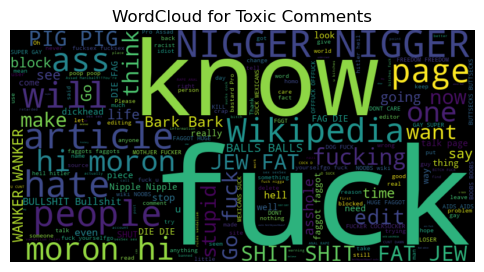

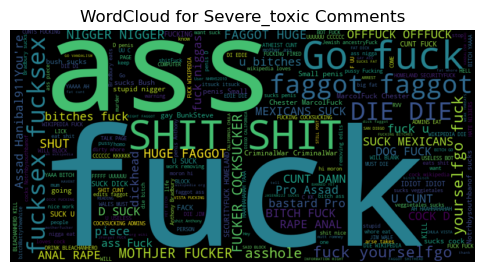

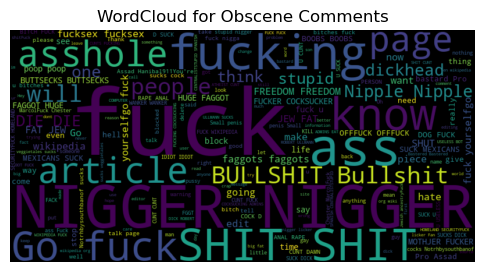

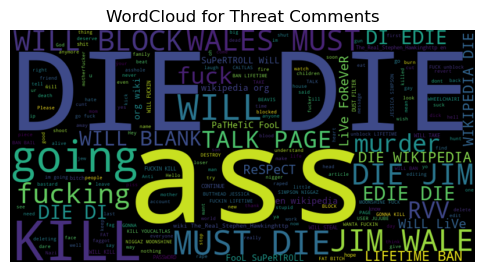

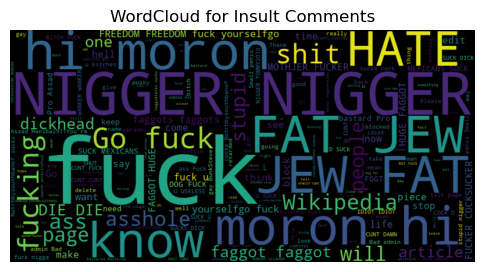

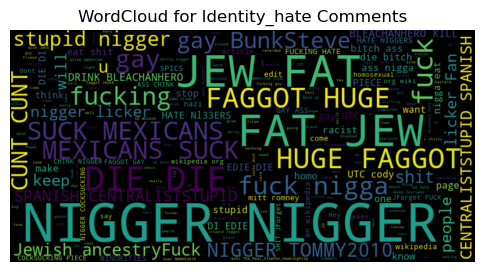

In [33]:
for label in labels_columns:
    labeled_comments = ' '.join(
        train_df[train_df[label] == 1]['comment_text'].tolist())
    wordcloud = WordCloud(width=800, height=400,
                          background_color='black').generate(labeled_comments)
    plt.figure(figsize=(6, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {label.capitalize()} Comments')
    plt.show()

### Correlation of word frequencies across labels

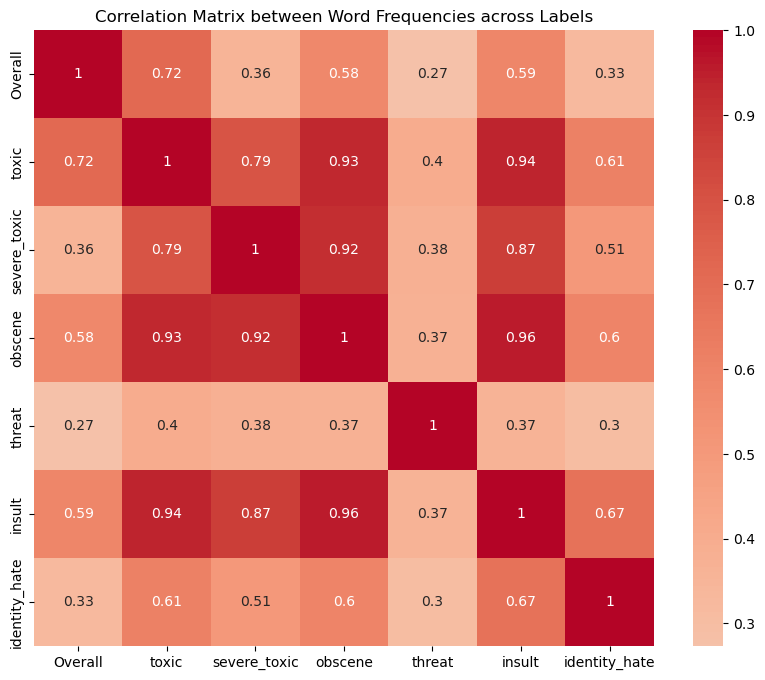

In [34]:
freq_df = freq_df.set_index('Word')
correlation_matrix = freq_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix between Word Frequencies across Labels')
plt.show()

---
- What is interesting here is that 'threat' labeled comments are less correlated than all other labels. Indicating there are more specific threat comment words than in general toxic categories.
- This insight could potentially be used to have separate categorizations for toxic and threat comments in terms of model architecture and outputs if possible. 
---

### Toxic vs non toxic comment typos frequencies

In [35]:
spell = SpellChecker()

def count_typos(text: str) -> int:
    """
    Counts the number of misspelled words in a text.
    """
    words = text.translate(str.maketrans('', '', string.punctuation)).split()
    misspelled = spell.unknown(words)
    return len(misspelled)

In [36]:
train_df['typo_count'] = train_df['comment_text'].apply(count_typos)
non_toxic_typo_avg = train_df[train_df['labels_sum'] == 0]['typo_count'].mean()
toxic_typo_avg = train_df[train_df['labels_sum'] > 0]['typo_count'].mean()

print(
    f"Average number of typos in non-toxic comments: {non_toxic_typo_avg:.2f}")
print(f"Average number of typos in toxic comments: {toxic_typo_avg:.2f}")

Average number of typos in non-toxic comments: 4.25
Average number of typos in toxic comments: 3.13


---
- It seems that non toxic comments have more typos than toxic comments, this is a bit surprising to me. 
- Although this method might not capture curse words that are far more prevelant in the toxic comments. So we might be missing out here. 
---

### Comment lengths analysis

/home/user/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/user/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


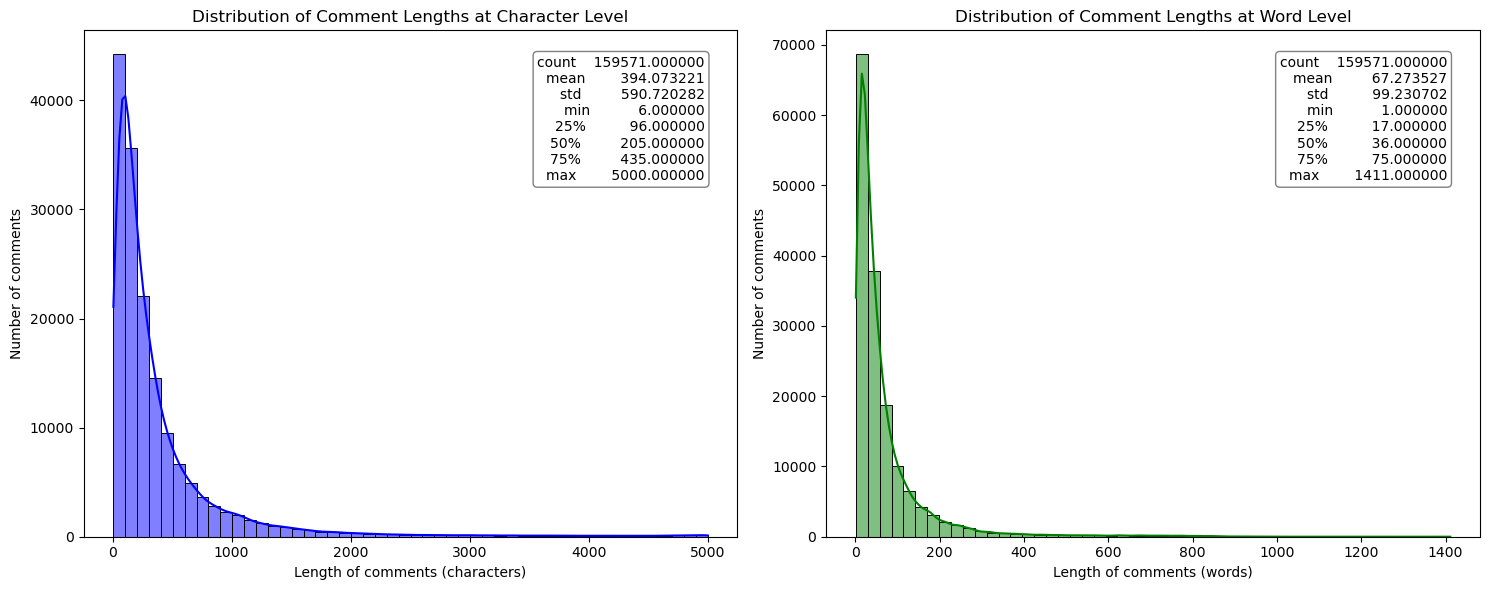

In [39]:
comment_char_lengths = train_df['comment_text'].apply(len)
comment_word_lengths = train_df['comment_text'].apply(lambda x: len(x.split()))

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.histplot(comment_char_lengths, bins=50, kde=True, color='blue', ax=axs[0])
axs[0].set_title('Distribution of Comment Lengths at Character Level')
axs[0].set_xlabel('Length of comments (characters)')
axs[0].set_ylabel('Number of comments')
axs[0].text(0.95, 0.95, comment_char_lengths.describe().to_string(),
            transform=axs[0].transAxes, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', fc='white', ec='gray'))

sns.histplot(comment_word_lengths, bins=50, kde=True, color='green', ax=axs[1])
axs[1].set_title('Distribution of Comment Lengths at Word Level')
axs[1].set_xlabel('Length of comments (words)')
axs[1].set_ylabel('Number of comments')
axs[1].text(0.95, 0.95, comment_word_lengths.describe().to_string(),
            transform=axs[1].transAxes, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', fc='white', ec='gray'))

plt.tight_layout()
plt.show()

---
- For word counts, we see that mean word count is 68 words. 
- Maximum is 1411, which is quite long for a comment. 
- Still at 75% we are only at 75 words. Meaning large number of comments is short, with minority being very long.
---

In [63]:
train_df['word_count'] = train_df['comment_text'].apply(
    lambda x: len(x.split()))
labels = ['toxic', 'severe_toxic', 'obscene',
          'threat', 'insult', 'identity_hate']
label_mean_lengths = {}
for label in labels:
    label_mean_lengths[label] = train_df.loc[train_df[label]
                                             == 1, 'word_count'].mean()

train_df['non_toxic'] = (train_df[labels].sum(axis=1) == 0).astype(int)
label_mean_lengths['non_toxic'] = train_df.loc[train_df['non_toxic']
                                               == 1, 'word_count'].mean()

train_df['label_count'] = train_df[labels].sum(axis=1)
label_mean_lengths['multi_label'] = train_df.loc[train_df['label_count']
                                                 > 1, 'word_count'].mean()

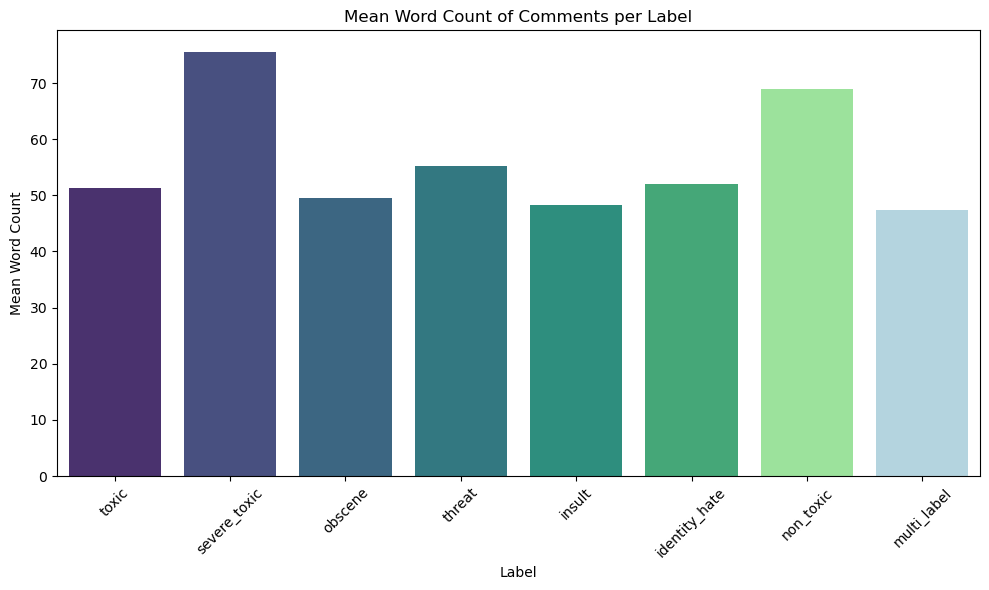

In [64]:
mean_lengths_df = pd.DataFrame(list(label_mean_lengths.items()), columns=['Label', 'Mean Word Count'])

color_palette = sns.color_palette("viridis", len(mean_lengths_df['Label'].unique()))
mean_lengths_df['Color'] = mean_lengths_df['Label'].apply(
    lambda x: 'lightgreen' if x == 'non_toxic' else ('lightblue' if x == 'multi_label' else color_palette.pop(0)))

plt.figure(figsize=(10, 6))
sns.barplot(x='Label', y='Mean Word Count', data=mean_lengths_df, palette=mean_lengths_df['Color'])
plt.title('Mean Word Count of Comments per Label')
plt.xlabel('Label')
plt.ylabel('Mean Word Count')
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()

---
- We don't see substantial differences besides sever_toxic and non_toxic ones being higher than the rest, multilabel comments also in mean range of others.
- severe_toxic are the longest. 

---

### Conclusion of EDA

- EDA gave quite interesting insights and relevance of various characteristics of comments such as capitalization ratio and use of exclamation marks. 

- We saw hof toxic comments differ from non toxic and how toxic differ within themselvs between eachoter. Despite them being quite similar for the most part we saw some differences in specific labels if we looked at correlations or frequency of symbols used. 

- Word wikipedia weirdly shows up as very frequent in toxic comments. Being used both ways in people's arguments.
- In my view some comments labeled as toxic that I encountered were not at all toxic in my estimation, some were quite disturbing though. We can clearly see some bias in the data labeling, but arguably it is impossible to classify every comment completely without bias, as we differ on perceptions of toxicity etc. 

---

#### What could be done better

- Language of comments analysis: I tried doing this but my method was quite bad, more advanced approach is needed, as there are comments with multiple languages, ad determining where to label language of that sort of comment is difficult. 

- Beginning and end of sentance analysis, are there some specific words or word sequences that are label specific?

- Looking into differet fonts, possibly doing ASCII normalization of comments. 

- More ratios, maybe length to capitalization or exclamatiopn marks to capitalization ratios etc. 

- Trying to look deeper into comment origin as to see what platforms might be represented how in this dataset based on comment mentions, and replies/threads. 

